# News classification with topic models in gensim
News article classification is a task which is performed on a huge scale by news agencies all over the world. We will be looking into how topic modeling can be used to accurately classify news articles into different categories such as sports, technology, politics etc.

Our aim in this tutorial is to come up with some topic model which can come up with topics that can easily be interpreted by us. Such a topic model can be used to discover hidden structure in the corpus and can also be used to determine the membership of a news article into one of the topics.

For this tutorial, we will be using the Lee corpus which is a shortened version of the [Lee Background Corpus](http://www.socsci.uci.edu/~mdlee/lee_pincombe_welsh_document.PDF). The shortened version consists of 300 documents selected from the Australian Broadcasting Corporation's news mail service. It consists of texts of headline stories from around the year 2000-2001.

Accompanying slides can be found [here](https://speakerdeck.com/dsquareindia/pycon-delhi-lightening).

### Requirements
In this tutorial we look at how different topic models can be easily created using [gensim](https://radimrehurek.com/gensim/).
Following are the dependencies for this tutorial:
    - Gensim Version >=0.13.1 would be preferred since we will be using topic coherence metrics extensively here.
    - matplotlib
    - nltk.stopwords and nltk.wordnet
    - pyLDAVis
We will be playing around with 4 different topic models here:
    - LSI (Latent Semantic Indexing)
    - HDP (Hierarchical Dirichlet Process)
    - LDA (Latent Dirichlet Allocation)
    - LDA (tweaked with topic coherence to find optimal number of topics) and
    - LDA as LSI with the help of topic coherence metrics
First we'll fit those topic models on our existing data then we'll compare each against the other and see how they rank in terms of human interpretability.

All can be found in gensim and can be easily used in a plug-and-play fashion. We will tinker with the LDA model using the newly added topic coherence metrics in gensim based on [this](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) paper by Roeder et al and see how the resulting topic model compares with the exsisting ones.

In [1]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now

import nltk
nltk.download('stopwords') # Let's make sure the 'stopword' package is downloaded & updated
nltk.download('wordnet') # Let's also download wordnet, which will be used for lemmatization

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/home/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
print(test_data_dir)
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'

/Users/home/Desenvolvimento/anaconda3/lib/python3.6/site-packages/gensim/test/test_data


Analysing our corpus.
    - The first document talks about a bushfire that had occured in New South Wales.
    - The second talks about conflict between India and Pakistan in Kashmir.
    - The third talks about road accidents in the New South Wales area.
    - The fourth one talks about Argentina's economic and political crisis during that time.
    - The last one talks about the use of drugs by midwives in a Sydney hospital.
Our final topic model should be giving us keywords which we can easily interpret and make a small summary out of. Without this the topic model cannot be of much practical use.

In [63]:
with open(lee_train_file) as f:
    for n, l in enumerate(f):
        if n < 6:
            print([l])

['Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year\'s Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are available at t

In [5]:
def build_texts(fname):
    """
    Function to build tokenized texts from file
    
    Parameters:
    ----------
    fname: File to be read
    
    Returns:
    -------
    yields preprocessed line
    """
    with open(fname) as f:
        for line in f:
            # Converte para lowercase, realiza tokenização e remove acentos 
            # Mantém tokens com no mínimo 3 caracteres
            yield gensim.utils.simple_preprocess(line, deacc=True, min_len=3)

In [53]:
train_texts = list(build_texts(lee_train_file))

In [7]:
len(train_texts)

300

### Preprocessing our data. Remember: Garbage In Garbage Out
                                        "NLP is 80% preprocessing."
                                                                -Lev Konstantinovskiy
This is the single most important step in setting up a good topic modeling system. If the preprocessing is not good, the algorithm can't do much since we would be feeding it a lot of noise. In this tutorial, we will be filtering out the noise using the following steps in this order for each line:
1. Stopword removal using NLTK's english stopwords dataset.
2. Bigram collocation detection (frequently co-occuring tokens) using gensim's [Phrases](https://radimrehurek.com/gensim/models/phrases.html). This is our first attempt to find some hidden structure in the corpus. You can even try trigram collocation detection.
3. Lemmatization (using gensim's [`lemmatize`](https://radimrehurek.com/gensim/utils.html#gensim.utils.lemmatize)) to only keep the nouns. Lemmatization is generally better than stemming in the case of topic modeling since the words after lemmatization still remain understable. However, generally stemming might be preferred if the data is being fed into a vectorizer and isn't intended to be viewed.

In [8]:
bigram = gensim.models.Phrases(train_texts)  # for bigram collocation detection

In [9]:
bigram[['new', 'york', 'example']]

['new_york', 'example']

In [10]:
from gensim.utils import lemmatize
from nltk.corpus import stopwords

In [11]:
stops = set(stopwords.words('english'))  # nltk stopwords list

In [66]:
def process_texts(texts, keep_all=True):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    texts = [[word for word in line if word not in stops] for line in texts]
    texts = [bigram[line] for line in texts]
    
    if keep_all is False:
        tagged = [nltk.pos_tag(line) for line in texts]
        #print(tagged)
        #texts = [[word for word in line if nltk.pos_tag(word)[1].startswith('NN')] for line in texts]
        #tagged = nltk.pos_tag(texts)
        #for tag in tagged:
        #    print(tag)
        texts = [[tag[0] for tag in tuples if tag[1].startswith('NN')] for tuples in tagged]
        #print(texts)
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    texts = [[word for word in lemmatizer.lemmatize(' '.join(line), pos='v').split()] for line in texts]

    return texts

In [67]:
train_texts = list(build_texts(lee_train_file))
train_texts = process_texts(train_texts, keep_all=False)
train_texts[5:6]

[['federal_government',
  'afghani',
  'asylum_seekers',
  'home',
  'environment',
  'government',
  'applications',
  'foreign_affairs',
  'minister_alexander',
  'downer',
  'claims',
  'process',
  'hold',
  'threat',
  'people',
  'asylum',
  'afghans',
  'matter',
  'britain',
  'countries',
  'europe',
  'taliban',
  'power',
  'taliban',
  'mass',
  'airlift',
  'island',
  'pacific',
  'island',
  'people',
  'operations',
  'airlift',
  'today',
  'asylum_seekers',
  'claims',
  'department',
  'immigration',
  'detainees',
  'christmas',
  'island',
  'spokesman',
  'decision']]

Finalising our dictionary and corpus

In [68]:
dictionary = Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

### Topic modeling with LSI
This is a useful topic modeling algorithm in that it can rank topics by itself. Thus it outputs topics in a ranked order. However it does require a `num_topics` parameter (set to 200 by default) to determine the number of latent dimensions after the SVD.

In [69]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [70]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  '0.277*"people" + 0.264*"government" + 0.186*"security" + 0.154*"today" + 0.147*"police" + 0.143*"force" + 0.129*"attacks" + 0.128*"day" + 0.118*"man" + 0.118*"sharon"'),
 (1,
  '-0.232*"fire" + 0.213*"sharon" + -0.201*"today" + -0.185*"sydney" + -0.179*"firefighters" + -0.172*"company" + 0.170*"arafat" + -0.162*"wales" + -0.138*"fires" + 0.131*"attacks"'),
 (2,
  '-0.322*"fire" + 0.320*"company" + -0.226*"firefighters" + -0.193*"sydney" + -0.178*"fires" + -0.169*"wales" + 0.165*"workers" + -0.147*"areas" + -0.141*"area" + 0.136*"unions"'),
 (3,
  '-0.264*"test" + 0.244*"force" + -0.190*"day" + -0.189*"match" + 0.152*"afghanistan" + -0.148*"company" + 0.145*"government" + -0.129*"side" + 0.128*"man" + -0.126*"team"'),
 (4,
  '-0.368*"company" + 0.267*"test" + 0.186*"day" + 0.183*"match" + 0.154*"force" + -0.134*"workers" + 0.133*"side" + 0.129*"team" + 0.119*"captain" + 0.115*"days"')]

In [71]:
lsitopics = lsimodel.show_topics(formatted=False)

### Topic modeling with [HDP](http://jmlr.csail.mit.edu/proceedings/papers/v15/wang11a/wang11a.pdf)
An HDP model is fully unsupervised. It can also determine the ideal number of topics it needs through posterior inference.

In [72]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [73]:
hdpmodel.show_topics()

[(0,
  '0.003*sharon + 0.002*khil + 0.002*government + 0.002*meteorology + 0.002*cyberspace + 0.002*arafat + 0.002*help + 0.002*offices + 0.002*hamas + 0.002*drawn + 0.001*war + 0.001*attacks + 0.001*replacement + 0.001*trading + 0.001*signs + 0.001*suburb + 0.001*security + 0.001*sas + 0.001*crew + 0.001*kissinger'),
 (1,
  '0.002*airline + 0.002*administrators + 0.002*foreign_minister + 0.002*agreement + 0.002*police + 0.002*roed + 0.002*resolve + 0.002*troops + 0.002*today + 0.002*force + 0.002*senate + 0.002*security + 0.002*government + 0.002*exchanges + 0.002*power + 0.002*electricity + 0.001*virgin + 0.001*battling + 0.001*gunmen + 0.001*arrest'),
 (2,
  '0.003*airport + 0.002*half + 0.002*opposition + 0.002*baseless + 0.002*city + 0.002*party + 0.002*stage + 0.002*people + 0.002*warrants + 0.002*fought + 0.002*revenge + 0.002*afghan_forces + 0.002*residents + 0.002*night + 0.002*kashmir + 0.002*lali + 0.002*terms + 0.002*civilians + 0.002*troops + 0.002*zaman'),
 (3,
  '0.003*c

In [74]:
hdptopics = hdpmodel.show_topics(formatted=False)

### Topic modeling using [LDA](https://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf)
This is one the most popular topic modeling algorithms today. It is a generative model in that it assumes each document is a mixture of topics and in turn, each topic is a mixture of words. To understand it better you can watch [this](https://www.youtube.com/watch?v=DDq3OVp9dNA) lecture by David Blei. Let's choose 10 topics to initialize this.

In [75]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

pyLDAvis is a great way to visualize an LDA model. To summarize in short, the area of the circles represent the prevelance of the topic. The length of the bars on the right represent the membership of a term in a particular topic. pyLDAvis is based on [this](http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) paper.

In [76]:
import pyLDAvis.gensim

In [77]:
pyLDAvis.enable_notebook()

In [78]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/home/Desenvolvimento/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      17.479247        1       1 -0.074394 -0.026376
2      12.141722        1       2 -0.004790 -0.022449
7      10.344003        1       3 -0.031998  0.057971
6      10.330471        1       4  0.073451  0.015831
4      10.034759        1       5 -0.033812  0.045811
3       9.010825        1       6 -0.001259 -0.056567
1       8.319895        1       7  0.086517  0.033683
0       7.992608        1       8 -0.032756  0.037585
9       7.625603        1       9  0.020451 -0.077916
5       6.720867        1      10 -0.001410 -0.007573, topic_info=     Category       Freq           Term       Total  loglift  logprob
term                                                                 
593   Default  49.000000            man   49.000000  30.0000  30.0000
645   Default  16.000000        airline   16.000000  29.0000  29.0000
2335  Default  12.000000          space   12.000000  28.0000  28.0000
25    Default  41.000000           fire   41.000000  27.0000  27.0000
218   Default  13.000000          event   13.000000  26.0000  26.0000
448   Default  21.000000      agreement   21.000000  25.0000  25.0000
1521  Default  14.000000         qantas   14.000000  24.0000  24.0000
1502  Default  52.000000        company   52.000000  23.0000  23.0000
819   Default  19.000000         metres   19.000000  22.0000  22.0000
141   Default  93.000000     government   93.000000  21.0000  21.0000
518   Default  32.000000           test   32.000000  20.0000  20.0000
540   Default   8.000000         hewitt    8.000000  19.0000  19.0000
898   Default  18.000000          party   18.000000  18.0000  18.0000
250   Default  43.000000          world   43.000000  17.0000  17.0000
3656  Default   8.000000          virus    8.000000  16.0000  16.0000
1653  Default  13.000000           bill   13.000000  15.0000  15.0000
308   Default  14.000000       aircraft   14.000000  14.0000  14.0000
662   Default  13.000000       officers   13.000000  13.0000  13.0000
816   Default  15.000000          water   15.000000  12.0000  12.0000
1951  Default  20.000000          labor   20.000000  11.0000  11.0000
73    Default  59.000000         police   59.000000  10.0000  10.0000
542   Default  28.000000          month   28.000000   9.0000   9.0000
58    Default  19.000000   firefighters   19.000000   8.0000   8.0000
701   Default  11.000000           side   11.000000   7.0000   7.0000
913   Default  56.000000            day   56.000000   6.0000   6.0000
586   Default  26.000000        workers   26.000000   5.0000   5.0000
265   Default  16.000000          river   16.000000   4.0000   4.0000
2158  Default  23.000000         unions   23.000000   3.0000   3.0000
203   Default  36.000000  united_states   36.000000   2.0000   2.0000
52    Default  29.000000          areas   29.000000   1.0000   1.0000
...       ...        ...            ...         ...      ...      ...
354   Topic10   3.363623          house   19.235547   0.9562  -5.7491
3546  Topic10   0.898204     businesses    2.179410   1.8135  -7.0695
203   Topic10   4.708864  united_states   36.979697   0.6390  -5.4127
449   Topic10   5.591488       security   50.161191   0.5060  -5.2409
1659  Topic10   2.321004         sector   11.202208   1.1258  -6.1201
720   Topic10   3.273513          court   20.589139   0.8611  -5.7762
62    Topic10   3.708360      militants   25.596630   0.7681  -5.6515
3169  Topic10   1.450648          rates    5.138222   1.4353  -6.5901
593   Topic10   4.986633            man   49.928768   0.3961  -5.3553
129   Topic10   3.370896          years   24.471187   0.7176  -5.7469
51    Topic10   3.891581          state   33.592829   0.5445  -5.6033
141   Topic10   6.516505     government   93.928409   0.0318  -5.0878
73    Topic10   5.105199         police   59.305441   0.2475  -5.3318
834   Topic10   4.382622      australia   44.729412   0.3770  -5.4845
250   Topic10   4.2

In [79]:
ldatopics = ldamodel.show_topics(formatted=False)

### Finding out the optimal number of topics
__Introduction to topic coherence__:
<img src="https://rare-technologies.com/wp-content/uploads/2016/06/pipeline.png">
Topic coherence in essence measures the human interpretability of a topic model. Traditionally [perplexity has been used](http://qpleple.com/perplexity-to-evaluate-topic-models/) to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases. Here's a short blog I wrote explaining topic coherence:
[What is topic coherence?](https://rare-technologies.com/what-is-topic-coherence/)

In [80]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

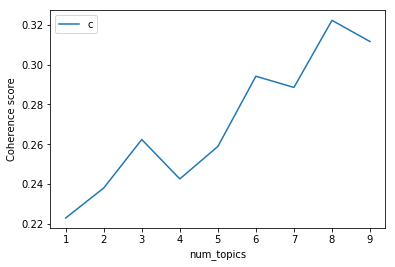

CPU times: user 32.8 s, sys: 533 ms, total: 33.3 s
Wall time: 34.3 s


In [81]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=10)

In [83]:
pyLDAvis.gensim.prepare(lmlist[7], corpus, dictionary)

/Users/home/Desenvolvimento/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      18.016827        1       1  0.035883  0.056169
2      14.479028        1       2  0.036580 -0.044328
1      14.187112        1       3  0.057755 -0.035033
5      13.175047        1       4 -0.068215 -0.000748
6      11.604578        1       5 -0.071077 -0.012759
0      10.718215        1       6  0.012763  0.066260
3       9.752707        1       7 -0.006214  0.011408
4       8.066487        1       8  0.002524 -0.040970, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
141   Default   88.000000      government   88.000000  30.0000  30.0000
1340  Default   20.000000         economy   20.000000  29.0000  29.0000
1951  Default   19.000000           labor   19.000000  28.0000  28.0000
518   Default   32.000000            test   32.000000  27.0000  27.0000
3656  Default    6.000000           virus    6.000000  26.0000  26.0000
250   Default   42.000000           world   42.000000  25.0000  25.0000
1502  Default   54.000000         company   54.000000  24.0000  24.0000
1     Default  103.000000          people  103.000000  23.0000  23.0000
25    Default   42.000000            fire   42.000000  22.0000  22.0000
387   Default   25.000000           peace   25.000000  21.0000  21.0000
192   Default   29.000000           power   29.000000  20.0000  20.0000
12    Default   33.000000          sydney   33.000000  19.0000  19.0000
2106  Default   10.000000             hih   10.000000  18.0000  18.0000
1407  Default   10.000000         disease   10.000000  17.0000  17.0000
1379  Default    7.000000         macgill    7.000000  16.0000  16.0000
3398  Default    4.000000        products    4.000000  15.0000  15.0000
2335  Default   12.000000           space   12.000000  14.0000  14.0000
774   Default   16.000000            rate   16.000000  13.0000  13.0000
1014  Default   16.000000          damage   16.000000  12.0000  12.0000
40    Default   35.000000            area   35.000000  11.0000  11.0000
88    Default   23.000000          troops   23.000000  10.0000  10.0000
403   Default   28.000000           union   28.000000   9.0000   9.0000
352   Default    7.000000             car    7.000000   8.0000   8.0000
834   Default   45.000000       australia   45.000000   7.0000   7.0000
1292  Default   15.000000           child   15.000000   6.0000   6.0000
2837  Default    5.000000         farmers    5.000000   5.0000   5.0000
102   Default   29.000000             war   29.000000   4.0000   4.0000
3141  Default    5.000000  world_heritage    5.000000   3.0000   3.0000
205   Default    6.000000           seles    6.000000   2.0000   2.0000
2158  Default   24.000000          unions   24.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
1630   Topic8    1.875852            food    5.430599   1.4545  -6.5155
88     Topic8    4.839411          troops   23.112240   0.9539  -5.5678
1      Topic8   12.249046          people  103.347029   0.3848  -4.6392
12     Topic8    5.879636          sydney   33.700594   0.7714  -5.3731
1156   Topic8    2.235104      population    7.245332   1.3414  -6.3403
141    Topic8   10.400400      government   88.798683   0.3729  -4.8028
292    Topic8    3.490814             lot   15.896777   1.0015  -5.8945
25     Topic8    6.050481            fire   42.077801   0.5781  -5.3445
881    Topic8    3.535067         defence   16.964224   0.9491  -5.8819
130    Topic8    2.328633       recession    8.175081   1.2616  -6.2993
32     Topic8    5.286467            year   36.514071   0.5849  -5.4795
131    Topic8    4.830655            days   31.185562   0.6525  -5.5696
153    Topic8    3.969329            work   21.860154   0.8114  -5.7660
371    Topic8    2.859478       buildings   12.117120   1.0735  -6.0940
518    Topic8    3.865722        

In [84]:
lmtopics = lmlist[7].show_topics(formatted=False)

### LDA as LSI

One of the problem with LDA is that if we train it on a large number of topics, the topics get "lost" among the numbers. Let us see if we can dig out the best topics from the best LDA model we can produce. The function below can be used to control the quality of the LDA model we produce.

In [ ]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = LdaModel(corpus=corpus, id2word=dictionary)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
        print(top_topics)
    return lm, top_topics

In [ ]:
lm, top_topics = ret_top_model()

In [79]:
print(top_topics[:5])

[(91, 0.99286550077029223), (42, 0.96031455145699274), (54, 0.87011963575683104), (2, 0.84575428129030361), (10, 0.83238343784453017)]


### Inference
We can clearly see below that the first topic is about __cinema__, second is about __email malware__, third is about the land which was given back to the __Larrakia aboriginal community of Australia__ in 2000. Then there's one about __Australian cricket__. LDA as LSI has worked wonderfully in finding out the best topics from within LDA.

In [78]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

[[(u'actor', 0.034688196735986693),
  (u'picture', 0.023163878883499418),
  (u'award', 0.023163878883499418),
  (u'comedy', 0.023163878883499418),
  (u'globe', 0.023163878883499418),
  (u'nomination', 0.023163878883499418),
  (u'actress', 0.023163878883499418),
  (u'film', 0.023163878883499418),
  (u'drama', 0.011639561031012149),
  (u'winner', 0.011639561031012149)],
 [(u'virus', 0.064292949289013482),
  (u'user', 0.048074573973209883),
  (u'computer', 0.040350900997751814),
  (u'company', 0.028173623478117912),
  (u'email', 0.022580226976870982),
  (u'worm', 0.020928236506996975),
  (u'attachment', 0.014534311779706417),
  (u'outlook', 0.01260706654637953),
  (u'software', 0.011909411409069969),
  (u'list', 0.0088116041533348403)],
 [(u'claim', 0.0096511365969504694),
  (u'agreement', 0.0082836950379963047),
  (u'hectare', 0.0077564979304569235),
  (u'larrakia', 0.0065928813973845394),
  (u'rosebury', 0.006086042494624749),
  (u'term', 0.004880655853124416),
  (u'region', 0.004786636

In [98]:
lda_lsi_topics = [[word for word, prob in lm.show_topic(topicid)] for topicid, c_v in top_topics]

### Evaluating all the topic models
Any topic model which can come up with topic terms can be plugged into the coherence pipeline. You can even plug in an [NMF topic model](http://derekgreene.com/nmf-topic/) created with scikit-learn.

In [99]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

lmtopics = [[word for word, prob in topic] for topicid, topic in lmtopics]

In [100]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lm_coherence = CoherenceModel(topics=lmtopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_lsi_coherence = CoherenceModel(topics=lda_lsi_topics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

In [101]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

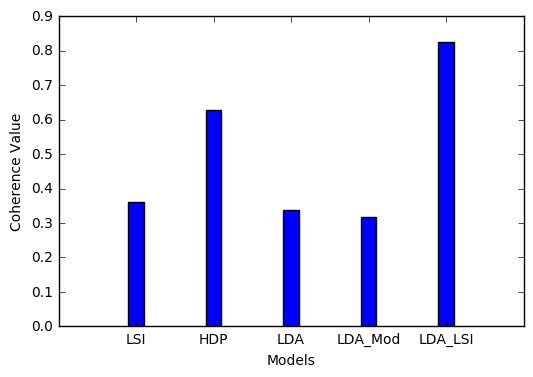

In [102]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, lm_coherence, lda_lsi_coherence],
                   ['LSI', 'HDP', 'LDA', 'LDA_Mod', 'LDA_LSI'])

### Customizing the topic coherence measure
Till now we only used the `c_v` coherence measure. There are others such as `u_mass`, `c_uci`, `c_npmi`. All of these calculate coherence in a different way. `c_v` is found to be most in line with human ratings but can be much slower than `u_mass` since it uses a sliding window over the texts.

### Making your own coherence measure
Let's modify `c_uci` to use `s_one_pre` instead of `s_one_one` segmentation

In [47]:
from gensim.topic_coherence import (segmentation, probability_estimation,
                                    direct_confirmation_measure, indirect_confirmation_measure,
                                    aggregation)
from gensim.matutils import argsort
from collections import namedtuple

In [48]:
make_pipeline = namedtuple('Coherence_Measure', 'seg, prob, conf, aggr')

In [49]:
measure = make_pipeline(segmentation.s_one_one,
                        probability_estimation.p_boolean_sliding_window,
                        direct_confirmation_measure.log_ratio_measure,
                        aggregation.arithmetic_mean)

To get topics out of the topic model:

In [50]:
topics = []
for topic in lm.state.get_lambda():
    bestn = argsort(topic, topn=10, reverse=True)
topics.append(bestn)

__Step 1__: Segmentation

In [51]:
# Perform segmentation
segmented_topics = measure.seg(topics)

__Step 2__: Probability estimation

In [52]:
# Since this is a window-based coherence measure we will perform window based prob estimation
per_topic_postings, num_windows = measure.prob(texts=train_texts, segmented_topics=segmented_topics,
                                               dictionary=dictionary, window_size=2)

__Step 3__: Confirmation Measure

In [53]:
confirmed_measures = measure.conf(segmented_topics, per_topic_postings, num_windows, normalize=False)

__Step 4__: Aggregation

In [54]:
print(measure.aggr(confirmed_measures))

-11.2873225334


# How this topic model can be used further
The best topic model here can be used as a standalone for news article classification. However a topic model can also be used as a dimensionality reduction algorithm to feed into a classifier. A good topic model should be able to extract the signal from the noise efficiently, hence improving the performance of the classifier.